In [1]:
import pandas as pd
import numpy as np
import random
import sklearn
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
import sklearn.metrics as metrics
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [2]:
#importujemy dane
df = pd.read_csv("zbior_uczacy.csv", index_col="Id")

In [3]:
df.head()

,GlebokaNiewyplacalnosc2Y,UzycieLiniiKredytowych,Wiek,IloscDo30.59DPD,WskaznikZadluzenia,DochodMiesieczny,LiczbaProduktowKredytowych,Ilosc90DPD,LiczbaHipotek,IloscDo60.89DPD,IloscOsobNaUtrzymaniu,LiczbaLosowa
Id,,,,,,,,,,,,
1,0,0.000000,68,0,0.634675,1614.0,9,0,1,0,1.0,4.353933e-07
2,0,0.235419,57,0,0.626126,2885.0,7,0,1,0,1.0,1.553004e-05
3,0,0.338259,48,0,0.358659,3250.0,8,0,0,0,0.0,1.604133e-05
4,0,0.425931,49,0,0.512522,4551.0,9,0,2,0,2.0,2.183206e-05
5,1,0.965058,48,0,0.122373,4804.0,3,0,0,0,2.0,2.428214e-05


<h4>Mamy do czynienia z nierównomiernie rozłożonymi klasami (ang. "skewed classes")</h4>

Przy trenowaniu modelu musimy upewnić się, że model nie ma biasu w kierunku liczebniejszej klasy oraz ustalić inną metrykę błędu niż precyzja (ang. "accuracy"). Zauważmy, że model, który w każdym przypadku przewidywałby "0" miałby około 93.32% precyzji, a mimo to nie spełniałby naszych oczekiwań. Dlatego przy ocenie modelu posłużymy się krzywą ROC oraz polem powierzchni pod nią (AUC). Na poniższym wykresie przedstawiony jest rozkład klas.

Kategoria pozytywna: 8013 | 6.68% wszystkich instancji
Kategoria negatywna: 111987 | 93.32% wszystkich instancji


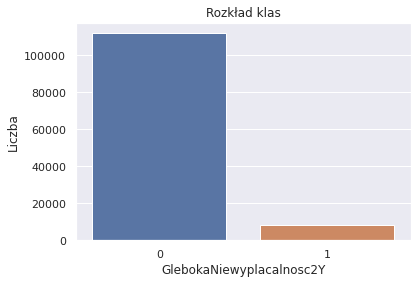

In [4]:
positives = sum(df["GlebokaNiewyplacalnosc2Y"] == 1)
negatives = sum(df["GlebokaNiewyplacalnosc2Y"] == 0)
print(f"Kategoria pozytywna: {positives} | {round(positives/df.shape[0]*100,2)}% wszystkich instancji")
print(f"Kategoria negatywna: {negatives} | {round(negatives/df.shape[0]*100,2)}% wszystkich instancji")
plt.figure(figsize=(6,4))
sns.countplot(df["GlebokaNiewyplacalnosc2Y"])
plt.ylabel("Liczba")
plt.title("Rozkład klas")
plt.show()

<h4>Przyjrzyjmy się korelacji cech</h4>

Istnieje duża korelacja pozytywna pomiędzy liczbami opóźnień w spłatach oraz pomiędzy liczbą produktów kredytowych a liczbą hipotek (co jest faktem oczywistym). Korelacja negatywna występuje pomiędzy wiekiem a liczbą osób na utrzymaniu. Ponadto korelacja pomiędzy liczbą losową a głęboką niewypłacalnością jest praktycznie zerowa, przez co możemy tę cechę zignorować (przy tak dużej ilości danych ta cecha nie powinna doprowadzić do overfittingu, jednak nie zaszkodzi ją usunąć).

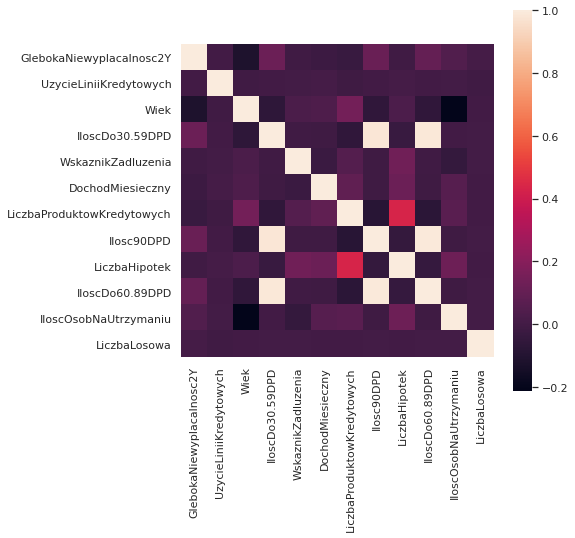

In [5]:
corr = df.corr()
plt.figure(figsize=(7,7))
sns.heatmap(corr, square=True)
plt.show()

In [6]:
#korelacja pomiędzy LiczbaLosowa a innymi cechami
corr['LiczbaLosowa']

GlebokaNiewyplacalnosc2Y      0.005439
UzycieLiniiKredytowych       -0.004760
Wiek                          0.000010
IloscDo30.59DPD               0.003457
WskaznikZadluzenia            0.003057
DochodMiesieczny             -0.001972
LiczbaProduktowKredytowych   -0.002345
Ilosc90DPD                    0.002824
LiczbaHipotek                -0.004366
IloscDo60.89DPD               0.002886
IloscOsobNaUtrzymaniu         0.000989
LiczbaLosowa                  1.000000
Name: LiczbaLosowa, dtype: float64

<h4>Brakujące dane</h4>

W prawie 20% przypadków nie znamy dochodu miesięcznego, a w około 2,5% przypadków nie znamy liczby osób na utrzymaniu. Jednym ze sposobów poradzenia sobie z brakującymi danymi byłoby zignorowanie instancji, w których brakuje danych. Jednak w tym przypadku wiązałoby się to z utratą znacznej ilości danych. Zastąpimy brakujące dane pewną metodą regresyjną oraz stworzymy dodatkową kolumnę, w której zaznaczymy, że w tym miejscu brakowało konkretnych danych (być może cenną informacją okaże się fakt, że brakuje na przykład miesięcznego dochodu, czego powodem mogło być chociażby ukrywanie go przez osobę ubiegającą się o kredyt).

In [7]:
#procentowy brak danych dla poszczególnych cech
missing = df.isnull().sum()/df.shape[0]
print(round(missing*100,2))

GlebokaNiewyplacalnosc2Y       0.00
UzycieLiniiKredytowych         0.00
Wiek                           0.00
IloscDo30.59DPD                0.00
WskaznikZadluzenia             0.00
DochodMiesieczny              19.84
LiczbaProduktowKredytowych     0.00
Ilosc90DPD                     0.00
LiczbaHipotek                  0.00
IloscDo60.89DPD                0.00
IloscOsobNaUtrzymaniu          2.61
LiczbaLosowa                   0.00
dtype: float64


<h4>Data preprocessing</h4>

Przygotujemy nasze dane w następującej kolejności:
- usuniemy zbędną kolumnę "LiczbaLosowa"
- stworzymy dodatkową kolumnę, w której zaznaczymy, czy brakuje jakiś informacji
- stworzymy dodatkową kolumnę, w której obliczymy dochód na jednego członka rodziny
- uzupełnimy brakujące dane IterativeImputerem (regresyjna metoda uzupełniania brakujących danych - zwiększyła AUROC walidacyjny o ponad 1.5%!)
- standaryzujemy dane przy użyciu RobustScaler'a (standaryzowanie danych nie pomogło w uzyskaniu wyższego AUROCA walidacyjnego, przez co ostatecznie z tego zrezygnowałem)

In [8]:
df_new = df.copy()

#tworzymy nową tabelę "DochodNaOsobe"
df_new['DochodNaOsobe'] = pd.Series(df_new.DochodMiesieczny/(df_new.IloscOsobNaUtrzymaniu+1))

#usuwamy zbedną kolumnę "LiczbaLosowa"
df_clean = df_new.drop(['LiczbaLosowa'], axis=1)

#tworzymy kolumnę z informacją, czy brakowało konkretnych danych
data_complete = df_clean.copy()
data_complete['Brakuje_DochodMiesieczny'] = np.where(df.DochodMiesieczny.isnull(), 1, 0)
data_complete['Brakuje_IloscOsobNaUtrzymaniu'] = np.where(df.IloscOsobNaUtrzymaniu.isnull(), 1, 0)
data_preprocessed = data_complete.copy()

<h4>Dzielimy dataset na dane uczące oraz dane walidacyjne</h4>

Zbiór danych jest stosunkowo duży (120000 rekordów), jednak mamy do czynienia ze niezbalansowanymi danymi, co oznacza, że klasa mniejszości występuje tu dużo rzadziej od klasy większości (GlebokaNiewyplacalnosc2Y przyjmuje wartość "1" dla około 6.7% rekordów). W związku z tym podzielimy dane w stosunku 80:20 (w danych walidacyjnych znajdzie się wówczas około 1600 pozytywnych klas, co pozwoli na stosunkowo dobrą generalizację).

In [9]:
data_preprocessed_array = np.array(data_preprocessed)
X = data_preprocessed_array[:,1:]
Y = data_preprocessed_array[:,0] 
X_train_raw, X_val_raw, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, shuffle=True, random_state=120)

#uzupełniamy brakujące dane
Imputer = IterativeImputer(max_iter=100, random_state=10)
Imputer.fit(X_train_raw)
X_train = Imputer.transform(X_train_raw)
X_val = Imputer.transform(X_val_raw)

#sprawdzamy, czy w danych walidacyjnych stosunek obu klas jest zbliżony do stosunku klas w całym datasecie
print(f"{round(sum(Y_val)/Y_val.shape[0]*100,2)}%") 

6.73%


<h4>Tworzymy model XGBoost</h4>

Po przetestowaniu różnych modeli (w tym RandomForestClassifier oraz sieć neuronowa w Kerasie) model XGBoost okazał się najskuteczniejszy pod względem metryki błędu AUROC na danym datasecie. Jest on dosyć szybki i dobrze radzi sobie z niezbalansowanymi danymi. Optymalne hiperparametry naszego klasyfikatora znaleźliśmy za pomocą "grid-" oraz "random searchu".

In [12]:
#przeszukamy n klasyfikatorów XGBoost z losowo wybranymi hiperparametrami 
#z pewnego zakresu, który zawężaliśmy w oparciu o kolejne obserwacje
n = 8
best_auroc = 0 #dotychczas najwyższy AUROC
best_clf = None #model o najwyżym AUROCU

with open('record.txt', 'a') as file:
    file.write('--------\n')
    for i in range(n):
        
        learning_rate = round(random.uniform(0.04,0.07),5)
        max_depth = random.randint(4,5)
        subsample = round(random.uniform(0.65,0.75),5)
        gamma = round(random.uniform(0.06,0.09),5)
        min_child_weight = random.randint(3,5)
        
        clf = xgb.XGBClassifier(objective="binary:logistic", 
                                learning_rate = learning_rate,
                                min_child_weight = min_child_weight,
                                n_estimators = 4000,
                                gamma = gamma,
                                max_depth = max_depth,
                                subsample = subsample,
                                random_state = 100)
        
        pm = [learning_rate, max_depth, subsample, gamma, min_child_weight] #hiperparamametry w liście dla skrócenia zapisu
        print(f"Learning_rate: {pm[0]} | Max_depth: {pm[1]} | Subsample: {pm[2]} | Gamma: {pm[3]} | Min_child_weight: {pm[4]}")
        
        clf.fit(X_train, Y_train, eval_metric='auc', verbose=50,
                eval_set=[(X_val, Y_val)], early_stopping_rounds=300) #early_stopping zapobiega overfittingowi
        
        proba = clf.predict_proba(X_val)[:,1]
        AUROC = metrics.roc_auc_score(Y_val, proba)
        
        #zapisujemy do pliku hiperparametry o dotychczas najwyższym AUROCu
        if best_auroc < AUROC:
            file.write(f"Best AUROC: {AUROC} | Pms: {pm[0]}, {pm[1]}, {pm[2]}, {pm[3]}, {pm[4]}\n")
            best_auroc = AUROC
            best_clf = clf

Learning_rate: 0.0565 | Max_depth: 5 | Subsample: 0.67687 | Gamma: 0.07931 | Min_child_weight: 3
[0]	validation_0-auc:0.84529
[50]	validation_0-auc:0.86266
[100]	validation_0-auc:0.86818
[150]	validation_0-auc:0.86904
[200]	validation_0-auc:0.86894
[250]	validation_0-auc:0.86824
[300]	validation_0-auc:0.86740
[350]	validation_0-auc:0.86696
[400]	validation_0-auc:0.86670
[450]	validation_0-auc:0.86657
[467]	validation_0-auc:0.86657
Learning_rate: 0.06389 | Max_depth: 4 | Subsample: 0.70537 | Gamma: 0.0624 | Min_child_weight: 5
[0]	validation_0-auc:0.82925
[50]	validation_0-auc:0.86191
[100]	validation_0-auc:0.86772
[150]	validation_0-auc:0.86867
[200]	validation_0-auc:0.86884
[250]	validation_0-auc:0.86826
[300]	validation_0-auc:0.86786
[350]	validation_0-auc:0.86770
[400]	validation_0-auc:0.86774
[450]	validation_0-auc:0.86736
[497]	validation_0-auc:0.86740
Learning_rate: 0.065 | Max_depth: 4 | Subsample: 0.65597 | Gamma: 0.06188 | Min_child_weight: 3
[0]	validation_0-auc:0.82929
[50]	

<h4>Sprawdzimy, czy model nie ma overfittingu</h4>

Model dobrze generalizuje dla danych walidacyjnych, co zauważamy po akceptowalnej różnicy wyników w metryce AUROC oraz krzywej ROC

In [13]:
proba_train = best_clf.predict_proba(X_train)[:,1]
fpr_train, tpr_train,_ = metrics.roc_curve(Y_train, proba_train)
AUROC_train = metrics.roc_auc_score(Y_train, proba_train)
proba_val = best_clf.predict_proba(X_val)[:,1]
fpr_val, tpr_val,_ = metrics.roc_curve(Y_val, proba_val)
AUROC_val = metrics.roc_auc_score(Y_val, proba_val)
print(f"AUROC dla danych uczących: {round(AUROC_train,4)}")
print(f"AUROC dla danych walidacyjnych: {round(AUROC_val,4)}")
print(f"Różnica: {round(AUROC_train - AUROC_val,4)}")

AUROC dla danych uczących: 0.8786
AUROC dla danych walidacyjnych: 0.8693
Różnica: 0.0093


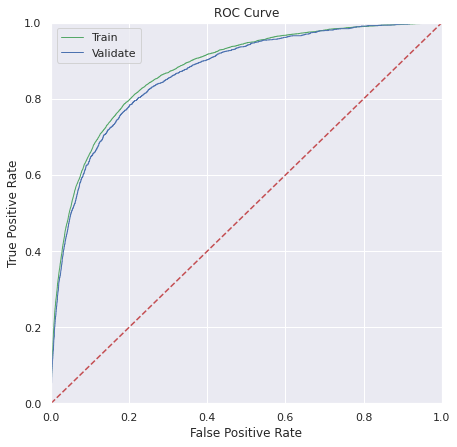

In [14]:
plt.figure(figsize=(7,7))
plt.plot(fpr_train, tpr_train, 'g', linewidth=1, label="Train")
plt.plot(fpr_val, tpr_val, 'b', linewidth=1, label="Validate")
plt.legend()
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title("ROC Curve")
plt.show()

<h4>Ważność cech</h4>

Model największą wagę przykłada do wartości cechy "Ilosc90DPD", co jest bardzo intuicyjne, ponieważ dotychczasowe niewypłacalności są silnym indykatorem tego, czy osoba spłaci kolejny kredyt. Również inne opóźnienia w spłatach mają wpływ na głęboką niewypłacalność. "UzycieLiniiKredytowych" oraz "Brakuje_DochodMiesieczny" są także znaczące dla predykcji modelu.

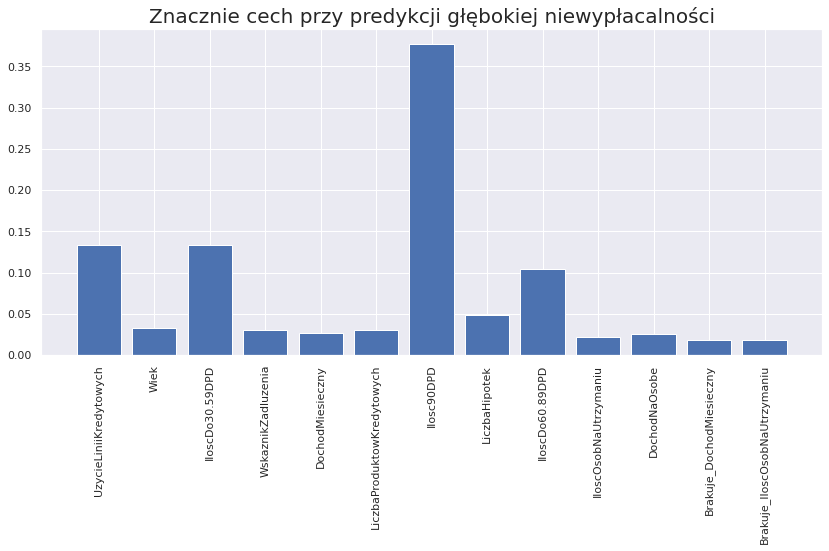

In [15]:
importance = best_clf.feature_importances_
features = data_complete.columns[1:]
plt.figure(figsize=(14,6))
plt.bar(range(len(importance)), importance, align="center")
plt.xticks(range(len(importance)), features, rotation=90)
plt.title("Znacznie cech przy predykcji głębokiej niewypłacalności", {"fontsize": 20})
plt.show()

<h4>Predykcja dla danych testowych</h4>

In [16]:
df_test = pd.read_csv("slepy_zbior_testowy.csv", index_col="Id")

In [17]:
ids = df_test.index.values
df_test_new = df_test.copy()
df_test_new['DochodNaOsobe'] = pd.Series(df_test_new.DochodMiesieczny/(df_test_new.IloscOsobNaUtrzymaniu+1))
df_test_clean = df_test_new.drop(['LiczbaLosowa'], axis=1)
data_test_complete = df_test_clean.copy()
data_test_complete['Brakuje_DochodMiesieczny'] = np.where(df_test.DochodMiesieczny.isnull(), 1, 0)
data_test_complete['Brakuje_IloscOsobNaUtrzymaniu'] = np.where(df_test.IloscOsobNaUtrzymaniu.isnull(), 1, 0)
data_test_preprocessed = data_test_complete.copy()
data_test_preprocessed = Imputer.transform(data_test_preprocessed)
X_test = data_test_preprocessed[:,1:]

In [18]:
probabilities = best_clf.predict_proba(X_test)[:,1]

In [19]:
with open('Odpowiedz_Olaf_Placha.csv', 'w') as file:
    file.write('Id,P\n')
    for i in range(len(ids)):
        file.write(f"{ids[i]},{probabilities[i]}\n")